# Insurance Model

##### `@author Dennis Kuzminer`


## Content

- [1. Problem Definition](#1)
- [2. Getting Started - Load Libraries and Dataset](#2)
  - [2.1. Load Libraries](#2-1)
  - [2.2. Load Dataset](#2-2)
- [3. Exploratory Data Analysis](#3)
  - [3.1 Descriptive Statistics](#3-1)
  - [3.2. Data Visualisation](#3-2)
  - [3.3. EDA Summary](#3-3)
- [4. Data Preparation and Feature Selection](#4)
  - [4.1. Preparing the Predictor Variables](#4-1)
  - [4.2. A Note on Feature Selection](#4-2)
- [5. Evaluate Algorithms and Models](#5)
  - [5.0. AutoML Attempt](#5-0)
  - [5.1. Find the best models](#5-1)
  - [5.2. Compare the models](#5-2)
  - [5.2.1. Split the data](#5-2-1)
  - [5.2.2. Initialize the models](#5-2-2)
  - [5.2.3. Fit the models](#5-2-3)
  - [5.2.4. The Actual Comparison...](#5-2-4)
- [6. Model Tuning/Grid Search](#6)
- [7. Results, Explanation, and Conclusion](#7)


<a id='1'></a>

# 1. Problem Definition


To develop and compare six different machine learning regression models to predict clients' insurance charges by first performing an EDA, then preprocessing the data, then build the models, and finally explaining the outputs.


<a id='2'></a>

# 2. Getting Started- Loading the data and python packages


<a id='2-1'></a>

## 2.1. Loading the python packages

Do not use Python 3.11, use 3.10. Pycaret does not work with 3.11


In [4]:
import sys


!{sys.executable} -m pip install numpy pandas pandas-datareader matplotlib scikit-learn keras statsmodels seaborn Jinja2 pycaret lightgbm --user


import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from matplotlib import pyplot


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from pycaret.regression import (
    setup,
    compare_models,
    tune_model,
    ensemble_model,
    blend_models,
    stack_models,
    automl,
)

<a id='2-2'></a>

## 2.2. Loading the Data


In [5]:
df = pd.read_csv("./insurance.csv")
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


<a id='3'></a>

# 3. Exploratory Data Analysis


<a id='3-1'></a>

## 3.1. Descriptive Statistics


In [90]:
df.shape


(1338, 7)

In [91]:
styled = df.describe().style
styled.set_properties(subset=["charges"], **{"background-color": "lightcoral"})
styled


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [92]:
df[["sex", "smoker", "region"]].value_counts()


sex     smoker  region   
female  no      southwest    141
                southeast    139
                northwest    135
male    no      southeast    134
female  no      northeast    132
male    no      northwest    132
                southwest    126
                northeast    125
        yes     southeast     55
                northeast     38
                southwest     37
female  yes     southeast     36
                northeast     29
                northwest     29
male    yes     northwest     29
female  yes     southwest     21
dtype: int64

<a id='3-2'></a>

## 3.2. Data Visualization


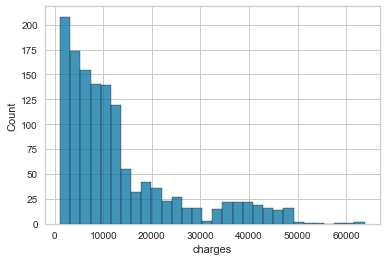

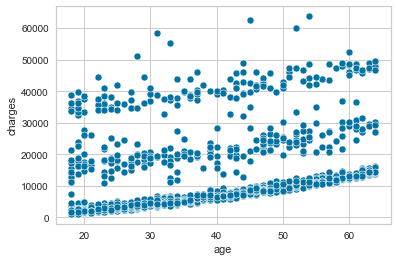

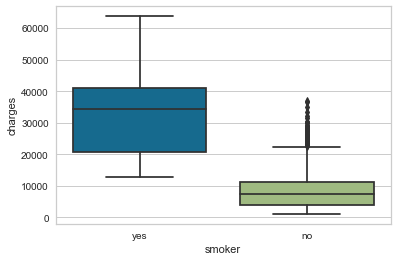

In [93]:
sns.histplot(df["charges"])
plt.show()
sns.scatterplot(x="age", y="charges", data=df)
plt.show()
sns.boxplot(x="smoker", y="charges", data=df)
plt.show()


From this data we can deduce a few things (which is confirmed by our intuition):

1. Charges tend to be lower than or around 10000.
2. As someone's age increases, they experience higher insurance charges.
3. Smokers will experience higher insurance charges over non-smokers. They also have a higher variability in their charges.

Let's really confirm...


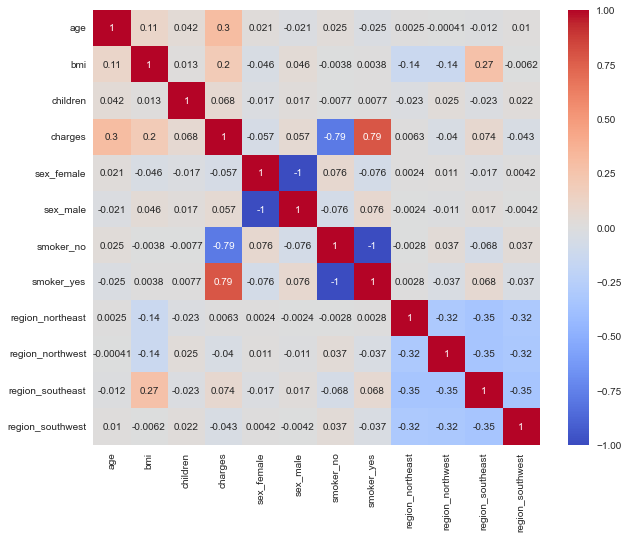

In [94]:
corr = pd.get_dummies(df, columns=["sex", "smoker", "region"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


So the main point here is that, yes, people that smoke have a positive correlation with charges. This relationship holds for age and bmi, but smoking is much more impactful.

Interestingly, we can also see that people from the southeast have a higher correlation to bmi, age, and smoking, which is why they see a higher correlation overall with charges.


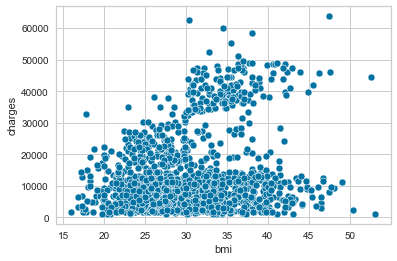

In [95]:
sns.scatterplot(x="bmi", y="charges", data=df)
plt.show()


One other thing to note here is that as someone's bmi increases, the variability of their charges increases.


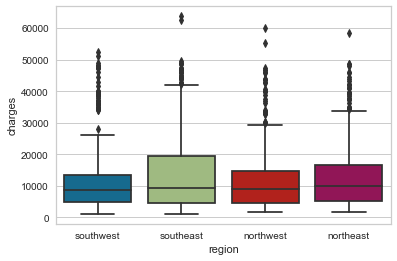

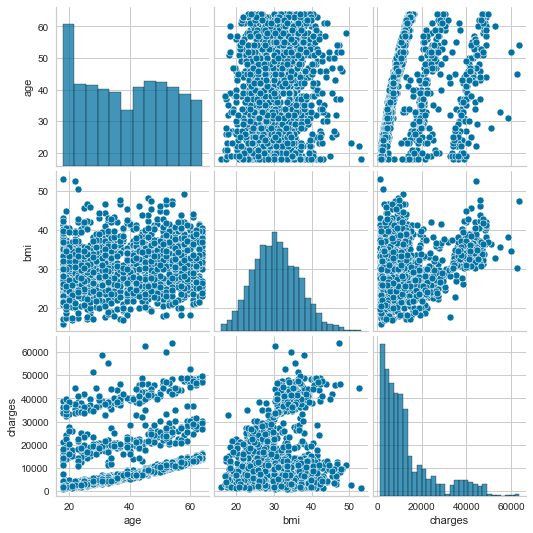

In [96]:
sns.boxplot(x="region", y="charges", data=df)
plt.show()
sns.pairplot(data=df[["age", "bmi", "charges"]])
plt.show()


...And a few last things we can pick up from this data.

1. We confirmed that sidenote about people from the southeast (Boxplot)
2. The data is skewed towards having more young people in the set (Pairplot top left)
3. BMI does not seem to have much a relationship with age (Pairplot top middle)
4. BMI is normally distributed (Pairplot center middle)


So in conclusion,
<a id="3-3"></a>

## 3.3. EDA Summary

1. People that smoke have a positive correlation with charges. This relationship holds for people who are older and have a higher BMI.
2. Charges tend to be lower than or around 10000.
3. Being a smoker tends to increase the variability of charge values. The same relationship happens when your BMI increases, but not so much as age increases.
4. There are more young people in the dataset.
5. BMI is normally distributed and does not seem to have much a relationship with age
6. I would say that the sample might not be representative of the population for that note about the southeast having people with higher BMIs, but that's not really true. You see, the southeast just has more obese people. Look at this cool map I found that ranks states on obesity and overweight prevalence (hover your mouse over it)! Pretty cool right?... well actually probably not that cool :(
<iframe src="https://cdn.wallethub.com/wallethub/embed/16585/geochart-sedentary-2022.html" width="556" height="347" frameBorder="0" scrolling="no"></iframe><div style="width:556px;font-size:12px;color:#888;">Source: <a href="https://wallethub.com/edu/fattest-states/16585">WalletHub</a></div>


<a id="4"></a>

# 4. Data Preparation and Feature Selection


<a id="4-1"></a>

## 4.1. Preparing the Predictor Variables


First, clean up the data set.


In [97]:
print("Null Values =", df.isnull().values.any())


Null Values = False


Lucky us, looks like we have clean data


Then, let's encode the categorical variables and scale the numerical variables


In [7]:
encoder = OneHotEncoder()
encoded_vars = encoder.fit_transform(df[["sex", "smoker", "region"]]).toarray()

scaler = StandardScaler()
scaled_vars = scaler.fit_transform(df[["age", "bmi", "children"]])

transformed_df = pd.DataFrame(
    np.concatenate(
        (df[["charges", "age", "bmi", "children"]], scaled_vars, encoded_vars), axis=1
    ),
    columns=[
        "charges",
        "age",
        "bmi",
        "children",
        "age_scaled",
        "bmi_scaled",
        "children_scaled",
        "female",
        "male",
        "non-smoker",
        "smoker",
        "northeast",
        "northwest",
        "southeast",
        "southwest",
    ],
)
transformed_df


,charges,age,bmi,children,age_scaled,bmi_scaled,children_scaled,female,male,non-smoker,smoker,northeast,northwest,southeast,southwest
0,16884.92400,19.0,27.900,0.0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.55230,18.0,33.770,1.0,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4449.46200,28.0,33.000,3.0,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,21984.47061,33.0,22.705,0.0,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3866.85520,32.0,28.880,0.0,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,10600.54830,50.0,30.970,3.0,0.768473,0.050297,1.580926,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,2205.98080,18.0,31.920,0.0,-1.509965,0.206139,-0.908614,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,1629.83350,18.0,36.850,0.0,-1.509965,1.014878,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,2007.94500,21.0,25.800,0.0,-1.296362,-0.797813,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


<a id="4-2"></a>

## 4.2. A Note on Feature Selection

As a result of the predictor data being small (not too many predictor variables), I believe that all features provided are useful for predicting the target. Additionally, the target is provided as one of the columns, so there does not need to be any changes to the target.


<a id="5"></a>

# 5. Evaluate Algorithms and Models


<a id="5-0"></a>

## 5.0. AutoML Attempt


In [3]:
reg_experiment = setup(
    data=df, target="charges", categorical_features=["sex", "smoker", "region"]
)
top6 = compare_models(n_select=6)
# tune models
tuned_top6 = [tune_model(i) for i in top6]

# ensemble models
bagged_top6 = [ensemble_model(i) for i in tuned_top6]

# blend models
blender = blend_models(estimator_list=top6)

# stack models
stacker = stack_models(estimator_list=top6)

# automl
best = automl(optimize="Recall")
print(best)


,Description,Value
0,Session id,3208
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2581.2414,20741249.2914,4506.4940,0.8427,0.4499,0.3241,0.8950
lightgbm,Light Gradient Boosting Machine,2804.7389,23087117.6354,4760.6388,0.8250,0.5563,0.3620,0.8630
rf,Random Forest Regressor,2646.8238,23178493.5119,4761.4386,0.8237,0.4713,0.3256,0.9190
ada,AdaBoost Regressor,3893.7657,25770771.6470,5057.7750,0.8078,0.6025,0.6606,0.8140
et,Extra Trees Regressor,2748.7644,27234919.0746,5187.7093,0.7920,0.4978,0.3389,0.9930
ridge,Ridge Regression,4260.1778,37226026.8173,6088.6943,0.7210,0.6003,0.4279,0.6950
lar,Least Angle Regression,4250.1391,37225839.1729,6088.3928,0.7209,0.5976,0.4259,0.7160
llar,Lasso Least Angle Regression,4250.1369,37221639.1368,6088.0743,0.7209,0.6003,0.4259,0.7230
br,Bayesian Ridge,4255.8007,37226445.8414,6088.6085,0.7209,0.6152,0.4270,0.8920
lasso,Lasso Regression,4250.1384,37221658.1847,6088.0758,0.7209,0.6003,0.4259,0.7550


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3045.4977,25685892.9633,5068.1252,0.7749,0.4882,0.2827
1,2118.8171,13204802.3126,3633.8413,0.8906,0.6385,0.2671
2,2017.8170,12371619.4573,3517.3313,0.9282,0.4127,0.3029
3,2898.8855,27157145.0428,5211.2518,0.7305,0.5471,0.2911
4,2717.8173,20877270.5255,4569.1652,0.8738,0.4137,0.3351
5,2558.6000,21165842.0425,4600.6350,0.8453,0.3844,0.2766
6,2285.5402,16597623.4582,4074.0181,0.8870,0.4011,0.3212
7,3165.8070,28244256.8965,5314.5326,0.7761,0.4504,0.3033
8,2663.6179,17712597.6259,4208.6337,0.8797,0.3631,0.2641


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3188.6249,27495173.8815,5243.5841,0.7590,0.5675,0.3380
1,2489.0004,15311021.7421,3912.9301,0.8732,0.3772,0.2912
2,2308.5395,12752776.1854,3571.1029,0.9260,0.4229,0.3651
3,3051.9588,25966861.3103,5095.7690,0.7423,0.5264,0.3253
4,3165.8200,24123394.3078,4911.5572,0.8542,0.4293,0.3811
5,2567.7909,20761487.1392,4556.4775,0.8482,0.3996,0.2957
6,2538.9891,17085228.6167,4133.4282,0.8837,0.4265,0.3575
7,3108.6452,27598804.7768,5253.4565,0.7812,0.4841,0.3057
8,2852.1339,17816229.0494,4220.9275,0.8790,0.4178,0.2720


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2487.1314,26458593.4022,5143.7917,0.7681,0.5032,0.1999
1,1745.9868,13674322.6921,3697.8808,0.8867,0.3037,0.1739
2,1631.0893,11426832.2203,3380.3598,0.9337,0.3742,0.2409
3,2375.1787,25443063.2432,5044.1117,0.7475,0.5148,0.2027
4,2009.5800,20142030.0783,4487.9873,0.8782,0.3020,0.1589
5,2108.7732,21799048.0341,4668.9451,0.8407,0.3421,0.1844
6,1753.8353,14556796.2923,3815.3370,0.9009,0.2740,0.1575
7,2657.6209,27689497.0929,5262.0811,0.7805,0.4804,0.2565
8,2087.7195,18151639.7681,4260.4741,0.8767,0.3716,0.1727


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3222.4548,28297698.9422,5319.5582,0.7520,0.5197,0.3849
1,2514.5974,15454764.4080,3931.2548,0.8720,0.4413,0.3730
2,2610.5831,14756975.3673,3841.4809,0.9143,0.4610,0.4273
3,2949.1494,24610953.9615,4960.9429,0.7558,0.4936,0.3453
4,3114.7854,24451811.2657,4944.8773,0.8522,0.4933,0.4487
5,2990.1480,23834986.0369,4882.1088,0.8258,0.4607,0.3811
6,2643.5133,16813478.5638,4100.4242,0.8855,0.4654,0.4312
7,3057.3107,25833757.1859,5082.6919,0.7952,0.4414,0.3407
8,2833.6122,18006961.4743,4243.4610,0.8777,0.3914,0.3176


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2465.9971,25844750.6799,5083.7733,0.7735,0.5054,0.1682
1,1816.4448,15202613.8870,3899.0529,0.8741,0.2958,0.1410
2,1391.9382,11959910.2172,3458.3103,0.9306,0.3058,0.1339
3,2326.2869,25238870.0781,5023.8302,0.7496,0.4952,0.1608
4,2125.2628,20401303.8931,4516.7803,0.8767,0.2664,0.1327
5,2196.3535,24261928.0906,4925.6399,0.8227,0.3346,0.1533
6,1688.6404,16093245.4011,4011.6387,0.8904,0.2608,0.1250
7,2431.2871,26654051.9925,5162.7562,0.7887,0.4463,0.1935
8,2226.2006,20052075.2163,4477.9544,0.8638,0.3638,0.1498


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4476.8884,39179767.2640,6259.3744,0.6566,0.6281,0.4929
1,3990.0113,30000806.9264,5477.2992,0.7515,1.0184,0.4063
2,4169.5750,30319472.6967,5506.3121,0.8240,0.5728,0.5354
3,4443.0364,41348861.5569,6430.3080,0.5897,0.5472,0.3975
4,4694.1657,42900451.6401,6549.8436,0.7407,0.5236,0.5103
5,4076.2459,34693261.6508,5890.0986,0.7464,0.4745,0.4087
6,4422.2003,36894220.9299,6074.0613,0.7488,0.4727,0.4449
7,4111.0368,39399613.1863,6276.9111,0.6876,0.5857,0.3801
8,4527.5957,35997686.7139,5999.8072,0.7556,0.5067,0.4387


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2958.1819,26340221.9263,5132.2726,0.7692,0.5446,0.3561
1,1992.1089,12548328.2104,3542.3620,0.8961,0.3489,0.2600
2,2237.3441,13184112.5153,3630.9933,0.9235,0.4599,0.4000
3,2752.6125,23882942.4315,4887.0177,0.7630,0.5161,0.2907
4,2597.6512,21067835.2833,4589.9712,0.8726,0.4296,0.3466
5,2535.0435,20711554.6372,4550.9949,0.8486,0.4009,0.3023
6,2273.0918,15046134.2910,3878.9347,0.8976,0.4091,0.3388
7,3018.6772,26680087.6194,5165.2771,0.7885,0.4631,0.3258
8,2524.6712,16869988.6344,4107.3092,0.8854,0.3844,0.2818


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3790.7574,30281920.3759,5502.9011,0.7346,0.5456,0.4136
1,3379.8408,22644965.1251,4758.6726,0.8124,0.4120,0.3596
2,3431.4079,21269440.4788,4611.8804,0.8765,0.5037,0.4762
3,3770.0259,31813181.2543,5640.3175,0.6843,0.5555,0.3606
4,4008.5151,33449616.1898,5783.5643,0.7978,0.4725,0.4432
5,3402.4020,25119221.5284,5011.9080,0.8164,0.4302,0.3525
6,3738.9138,27774902.5737,5270.1900,0.8109,0.4716,0.4379
7,3747.1784,33543994.8843,5791.7178,0.7341,0.4893,0.3706
8,3477.5414,23221327.1503,4818.8512,0.8423,0.4528,0.3276


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2712.7960,25916719.1281,5090.8466,0.7729,0.5216,0.2721
1,1802.4523,12430489.0618,3525.6899,0.8970,0.3140,0.1995
2,1809.7869,12224241.0009,3496.3182,0.9290,0.3965,0.2772
3,2380.8543,23627722.0259,4860.8355,0.7656,0.4968,0.2121
4,2276.7854,20577816.9946,4536.2779,0.8756,0.3467,0.2282
5,2362.2889,21392601.3343,4625.2137,0.8436,0.3684,0.2436
6,1951.7599,14217310.9834,3770.5850,0.9032,0.2958,0.2045
7,2798.0717,26693570.7789,5166.5821,0.7884,0.4603,0.2756
8,2332.6128,17547883.7317,4189.0194,0.8808,0.3765,0.2164


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3099.8788,26332529.9725,5131.5232,0.7692,0.5149,0.3761
1,2387.0042,14762488.8483,3842.1984,0.8777,0.4342,0.3586
2,2484.7450,14150975.2311,3761.7782,0.9179,0.4596,0.4166
3,2703.8980,23334208.0341,4830.5495,0.7685,0.4717,0.3048
4,2896.2718,22607492.2121,4754.7337,0.8633,0.4824,0.4236
5,2933.6109,23702115.0913,4868.4818,0.8267,0.4602,0.3761
6,2545.9068,16555297.8750,4068.8202,0.8873,0.4699,0.4282
7,3084.0120,26066561.4274,5105.5422,0.7933,0.4504,0.3459
8,2758.3529,18136612.3565,4258.7102,0.8768,0.3890,0.3053


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2737.6785,26311826.0061,5129.5054,0.7694,0.5041,0.2276
1,2063.4826,15719851.1182,3964.8267,0.8698,0.3025,0.1803
2,1662.2830,12623794.0688,3552.9979,0.9267,0.3388,0.1971
3,2605.7355,26021001.4124,5101.0785,0.7418,0.4917,0.1999
4,2455.1924,22830151.4414,4778.0908,0.8620,0.3193,0.1997
5,2535.7753,25226055.4263,5022.5547,0.8156,0.3567,0.2089
6,1918.5945,16059706.4456,4007.4564,0.8907,0.2793,0.1782
7,2657.1884,27035798.8168,5199.5960,0.7857,0.4300,0.2224
8,2626.0570,21539935.1306,4641.1136,0.8537,0.3678,0.1911


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4404.0569,39303772.0343,6269.2720,0.6556,0.6458,0.4656
1,3906.5693,29846831.1804,5463.2253,0.7528,0.6010,0.3910
2,4024.1184,29334433.3741,5416.1272,0.8297,0.5599,0.4959
3,4439.2661,42228572.8727,6498.3516,0.5810,0.5668,0.3869
4,4584.9992,42754003.8601,6538.6546,0.7415,0.5082,0.4794
5,4008.9243,34322965.8496,5858.5805,0.7491,0.4541,0.3911
6,4383.5910,36974865.8615,6080.6962,0.7483,0.4673,0.4305
7,4073.4662,39062741.2386,6250.0193,0.6903,0.5736,0.3718
8,4509.4875,36296987.7705,6024.6981,0.7535,0.5068,0.4326


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3223.5443,26523853.0388,5150.1314,0.7676,0.5674,0.4281
1,2515.9120,15716106.0741,3964.3544,0.8698,0.4012,0.3308
2,2433.0475,12874275.1522,3588.0740,0.9253,0.4871,0.4632
3,2898.5315,24614240.2481,4961.2741,0.7558,0.4995,0.3064
4,2972.1270,21305587.1350,4615.7976,0.8712,0.4514,0.4146
5,2700.4546,21294808.0251,4614.6298,0.8443,0.4185,0.3259
6,2454.4337,16000536.3887,4000.0670,0.8911,0.4120,0.3613
7,3227.8214,27017719.4291,5197.8572,0.7858,0.4762,0.3908
8,2890.5242,18129838.1546,4257.9148,0.8769,0.3877,0.3126


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2887.9520,25594821.3832,5059.1325,0.7757,0.5490,0.3446
1,2309.8125,14639619.1813,3826.1755,0.8787,0.3554,0.2678
2,2401.3861,12946121.5447,3598.0719,0.9249,0.4641,0.4339
3,2704.6703,24662595.0916,4966.1449,0.7553,0.5303,0.2679
4,2706.5638,20064454.7144,4479.3364,0.8787,0.3823,0.3129
5,2375.7303,20322905.2366,4508.0933,0.8514,0.3691,0.2488
6,2169.4773,14250917.1600,3775.0387,0.9030,0.3784,0.3088
7,3073.8833,27226828.9507,5217.9334,0.7841,0.4694,0.3489
8,2559.2150,17209312.8146,4148.4109,0.8831,0.3722,0.2703


ValueError: Optimize method not supported. See docstring for list of available parameters.

<a id="5-1"></a>

## 5.1. Find the best models


In [6]:
reg_experiment = setup(
    data=df, target="charges", categorical_features=["sex", "smoker", "region"]
)
top6 = compare_models(n_select=6)


,Description,Value
0,Session id,8509
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2716.0969,23090624.7245,4696.1557,0.8342,0.4439,0.3154,2.0270
lightgbm,Light Gradient Boosting Machine,2958.5635,24713474.5116,4865.6779,0.8223,0.5233,0.3645,2.5920
rf,Random Forest Regressor,2876.0522,25817591.6199,4993.0714,0.8141,0.4793,0.3408,2.1400
ada,AdaBoost Regressor,4018.7923,26750448.9733,5129.3307,0.8048,0.5935,0.6537,1.9140
et,Extra Trees Regressor,2939.2847,29918118.0716,5390.9443,0.7836,0.4915,0.3355,2.2410
ridge,Ridge Regression,4312.0564,37762000.2783,6097.3379,0.7273,0.5804,0.4383,3.2850
br,Bayesian Ridge,4306.9052,37758979.9022,6097.1837,0.7273,0.5828,0.4374,1.8180
lar,Least Angle Regression,4300.6007,37755929.1579,6097.0434,0.7272,0.5878,0.4364,2.8740
llar,Lasso Least Angle Regression,4300.7787,37756011.2415,6097.0298,0.7272,0.5876,0.4364,2.1920
lasso,Lasso Regression,4300.7785,37755999.2514,6097.0288,0.7272,0.5876,0.4364,2.8950


<a id="5-2"></a>

## 5.2. Compare the models


Seems like

1. Gradient Boosting Regressor
2. Light Gradient Boosting Machine
3. Random Forest Regressor
4. AdaBoost Regressor
5. Extra Trees Regressor
6. Ridge Regression

are the top 6. Gradient Boosting Regressor is the best approximation here, as R^2, which is the how well the model's predictions estimate the actual data points, is highest.

Let's use some other comparators

<a id="5-2-1"></a>

### 5.2.1. Split the data


In [9]:
validation_size = 0.3
Y = transformed_df["charges"]
X = transformed_df.loc[:, transformed_df.columns != "charges"]
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size
)
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_validation.shape)
print("y_train.shape:", Y_train.shape)
print("y_test.shape:", Y_validation.shape)


X.shape: (1338, 14)
Y.shape: (1338,)
X_train.shape: (936, 14)
X_test.shape: (402, 14)
y_train.shape: (936,)
y_test.shape: (402,)


<a id="5-2-2"></a>

### 5.2.2. Initialize the models


In [77]:
num_folds = 10
scoring = "neg_mean_squared_error"
kfold_results = []
names = []

validation_results = []
train_results = []
models = []
models.append(("GBR", GradientBoostingRegressor()))
models.append(("LIGHTGBM", LGBMRegressor()))
models.append(("RF", RandomForestRegressor()))
models.append(("ADA", AdaBoostRegressor()))
models.append(("ET", ExtraTreesRegressor()))
models.append(("RIDGE", Ridge()))
results = {
    "name": [],
    "Average CV error": [],
    "Std CV Error": [],
    "Training Error": [],
    "Test Error": [],
}


<a id="5-2-3"></a>

### 5.2.3. Fit the models

We can see that the error is indeed aligned with what we saw earlier


In [10]:
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = -1 * cross_val_score(
        model, X_train, Y_train, cv=kfold, scoring=scoring
    )
    kfold_results.append(cv_results)
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    results["name"].append(name)
    results["Average CV error"].append(str(round(cv_results.mean(), 6)))
    results["Std CV Error"].append(str(round(cv_results.std(), 6)))
    results["Training Error"].append(str(round(train_result, 6)))
    results["Test Error"].append(str(round(validation_result, 6)))
pd.DataFrame(results)


,name,Average CV error,Std CV Error,Training Error,Test Error
0,GBR,23015080.362574,9439971.69597,13695679.861402,19927329.274182
1,LIGHTGBM,24637278.834971,9745144.812063,8153656.02631,20874483.372523
2,RF,25907989.72727,9662187.060046,3633769.176376,21954597.131784
3,ADA,27463709.364279,7200897.190691,27316703.514298,29015192.95816
4,ET,30104203.108291,9817790.296987,195722.345699,24080473.496008
5,RIDGE,37756710.004349,9025222.283416,36638041.692408,36711720.36393


<a id="5-2-4"></a>

### 5.2.4. The Actual Comparison...

Just a graphical representation of the data above.


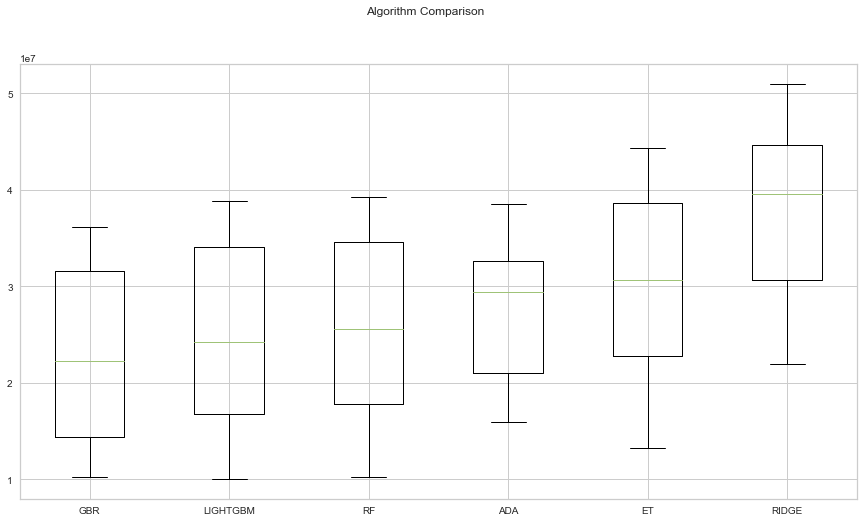

In [11]:
fig = pyplot.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(_results["name"])
fig.set_size_inches(15, 8)
pyplot.show()


Here is the less aggregate comparison. Looking at the plots, we can say that ridge is not appropriate for this data as there is a distinct trend line that deviates from 0. ADA slightly deviates from 0 as well. The model that deviates the least and appears to have the most randomness/trends the least in any direction is the GBR model. But why would GBR be better. First, GBR uses a collection of weak learners (making it an ensemble model) to create one stronger learners, which makes it good at generalizing, especially when outliers are involved **which are often present in insurance data**. These "learners" are decision trees that are continually combined in a way that minimizes error when fitting.


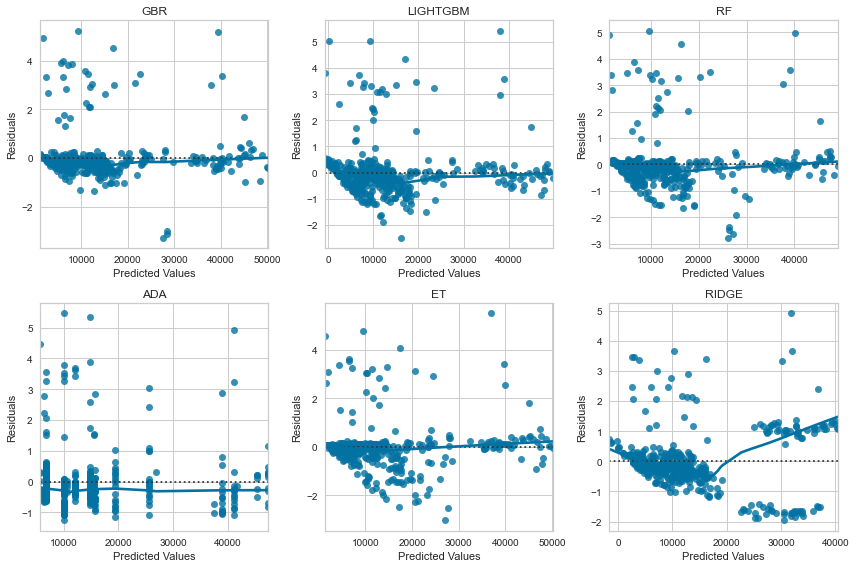

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.flatten()

for i, (name, model) in enumerate(models):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_validation)
    sns.residplot(x=y_pred, y=scale(Y_validation - y_pred), lowess=True, ax=axs[i])
    axs[i].set_xlabel("Predicted Values")
    axs[i].set_ylabel("Residuals")
    axs[i].set_title(name)

plt.tight_layout()
plt.show()


<a id="6"></a>

# 6. Model Tuning/Grid Search

We use negative mean squared error as a scoring method to try out different numbers of estimators. The goal here is determine the optimal number of trees to be constructed that benefits the model (reduces error without overfitting). GridSearchCV will do this search for us.


In [43]:
param_grid = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400]}
model = GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.DataFrame(
    {
        "mean_test_score": grid_result.cv_results_["mean_test_score"].round(2),
        "std_test_score": grid_result.cv_results_["std_test_score"].round(2),
        "params": grid_result.cv_results_["params"],
    }
)


Best: -21866920.004757 using {'n_estimators': 50}


,mean_test_score,std_test_score,params
0,-21866920.00,9494785.16,{'n_estimators': 50}
1,-23005414.39,9593926.91,{'n_estimators': 100}
2,-23716279.58,9773815.58,{'n_estimators': 150}
3,-24583369.63,9786119.64,{'n_estimators': 200}
4,-25255004.39,9899706.58,{'n_estimators': 250}
5,-26341176.34,10148218.91,{'n_estimators': 300}
6,-26878090.61,10067617.00,{'n_estimators': 350}
7,-27878364.85,10094173.19,{'n_estimators': 400}


Indeed 50 has lower error and a higher r^2


In [88]:
model = GradientBoostingRegressor(n_estimators=400)
model.fit(X_train, Y_train)
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))
print("-------")


model = GradientBoostingRegressor(n_estimators=50)
model.fit(X_train, Y_train)
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))


0.8821859745140692
19274965.44400229
0.8773540885596439
-------
0.9553345336792435
23681514.1920276
0.8493153774616641


<a id="7"></a>

# 7. Results, Explanation, and Conclusion

Visually, the model is showing lots of points along the x=y line, which is indicative that the model is a good predictor of the data. Outliers are not very far from the line, and points are tightly clustered. The residuals show a normal distribution around 0. There is a long tail, which could indicate that there are other factors that are in play that the data does not/can not take into account. Finally, (surprise, surprise) smoking contributes to your insurance costs. The impact that being a smoker has is much greater than that of BMI which is greater than that of age. The number of children and region are almost insignificant and does not influence your charges that much.


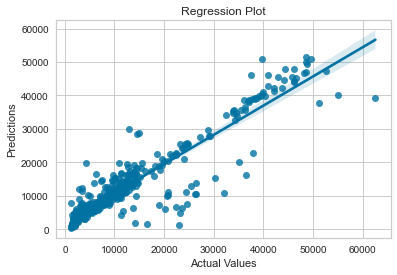

In [89]:
sns.regplot(x=Y_validation, y=predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Regression Plot")
plt.show()


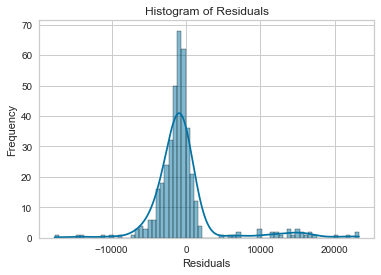

In [45]:
sns.histplot(Y_validation - predictions, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


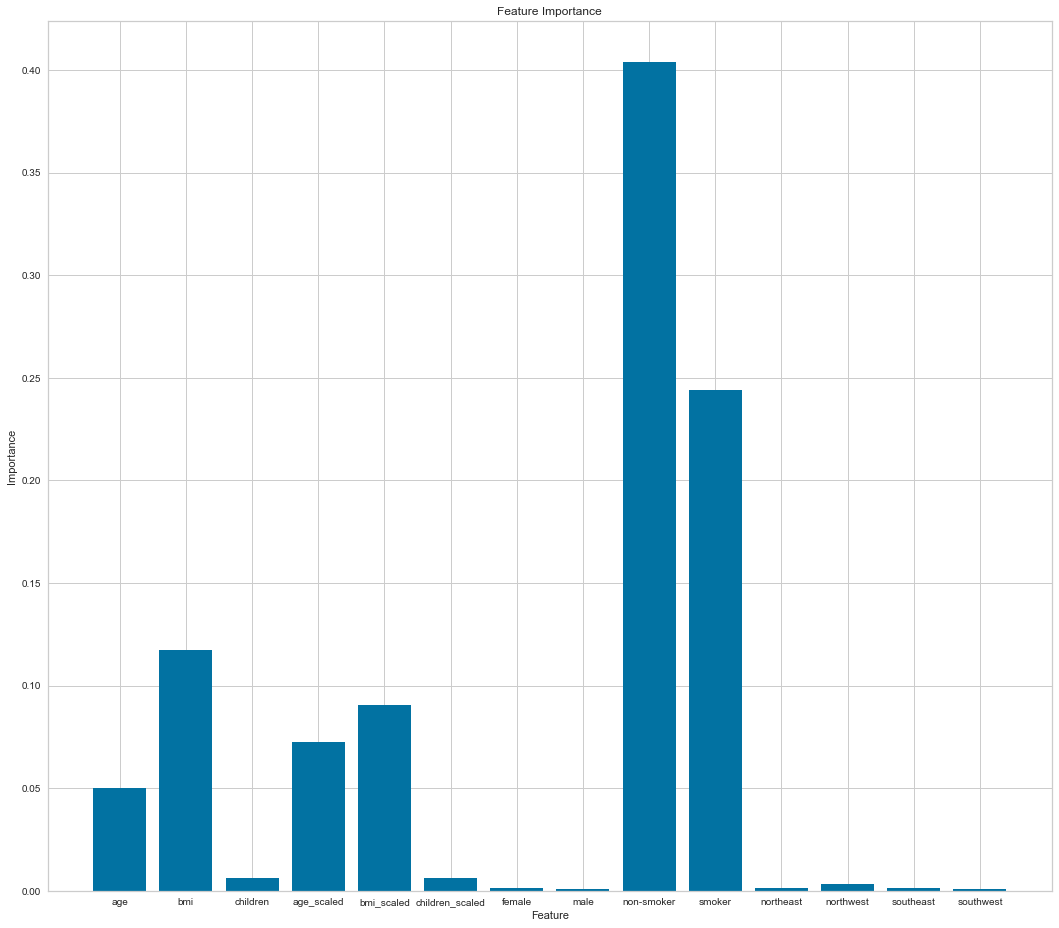

In [62]:
importance = model.feature_importances_
plt.subplots(figsize=(18, 16))
plt.bar(model.feature_names_in_, importance)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()
